# Time series reconstruction with Facebook Prophet

Before to get started, be sure to have dataset.csv in the input folder and prophet_utils.py in this same folder.

Import the required packages and we're ready to go.

Please note: the packages/modules installation phase is crucial and may require some time, especially PyStan.

In [17]:
%matplotlib inline
from prophet_utils import prepare_dataframe, suppress_stdout_stderr, create_results_dir
from fbprophet import Prophet
import os

First of all, if we want to work with Prophet, we need our dataset in a pandas dataframe with exactly two columns: 
   + **'y'** for the **time serie value**
   + **'ds'** for the **timestamp**

`prepare_dataframe` will convert our csv into a compatible dataframe. You should see the first five rows printed in console.

Note: If you're using a different dataset you should modify `prophet_utils.prepare_dataframe` in order to run the notebook correctly.

In [18]:
dataframe = prepare_dataframe('input/dataset.csv')
print("First 5 rows of input file:")
dataframe.head()

First 5 rows of input file:


,ds,y
0,2016-01-01 01:00:00,257.0500
1,2016-01-01 02:00:00,258.1625
2,2016-01-01 03:00:00,257.1625
3,2016-01-01 04:00:00,255.2375
4,2016-01-01 05:00:00,256.4875


We've imported a complete dataset, with no missing values. But if we want to test Prophet's reconstruction capabilities we need to erase some data.

We replace with `None` all the values between 01/04/2017 and 26/08/2017 (roughly 3 months).

For some dataset it may be useful clean some errors, they may become outliers and then affect the model. In this case we're working with power consumption data: a zero or negative power consumption is unlikely in most of cases, those values can be marked `None` as well.

In [19]:
dataframe.loc[('2017-04-01 00:00:00' <= dataframe['ds']) & 
              (dataframe['ds'] <= '2017-08-01 00:00:00'), 'y'] = None

dataframe.loc[(dataframe['y'] <= 0), 'y'] = None

The model can now be created and fitted with our dataframe.

You can see some parameters have been setted to a specified value: Prophet uses a STL decomposition to extract 
several trends, differentiated by the time granularity, from minutes to years. 

Increasing the seasonality parameter we fit with more accuracy, in fact **we're using an higher number of terms 
for the component approximation.**

Parameters' values depends on the time series nature, it's recommended to experiment with different combination in 
order to get the best reconstruction.

In [20]:
model = Prophet(daily_seasonality=20, yearly_seasonality=20)
model.fit(dataframe)

The model is ready, we need to create a new dataframe where store our results.

We take advantage of the situation, and we try to predict the power consumption for the next 24 hours: `periods` 
parameter is set to `24`, while we specify that our data have an hourly sampling. We also want a final dataframe 
containing the input values also, so `include_history` is set to `True`.

In [21]:
future = model.make_future_dataframe(periods=24, freq='H', include_history=True)
forecast = model.predict(future)

Finally, we plot our results: first the reconstruction, then a representation of STL components. In the first plot you 
can observe a confidence interval (light blue shadow).

/home/riccardo/PycharmProjects/power-predictor/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

/home/riccardo/PycharmProjects/power-predictor/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



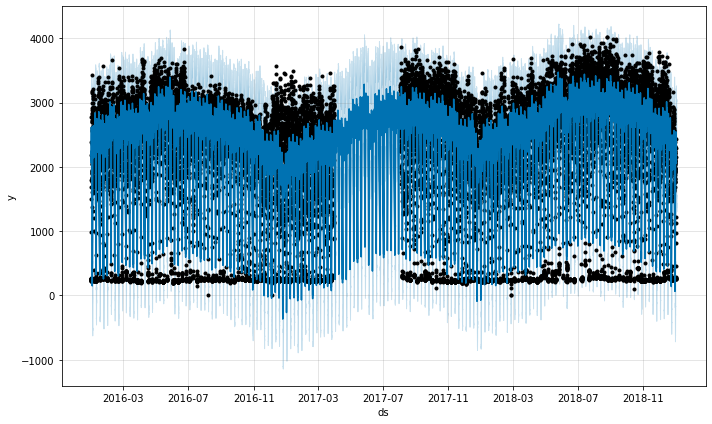

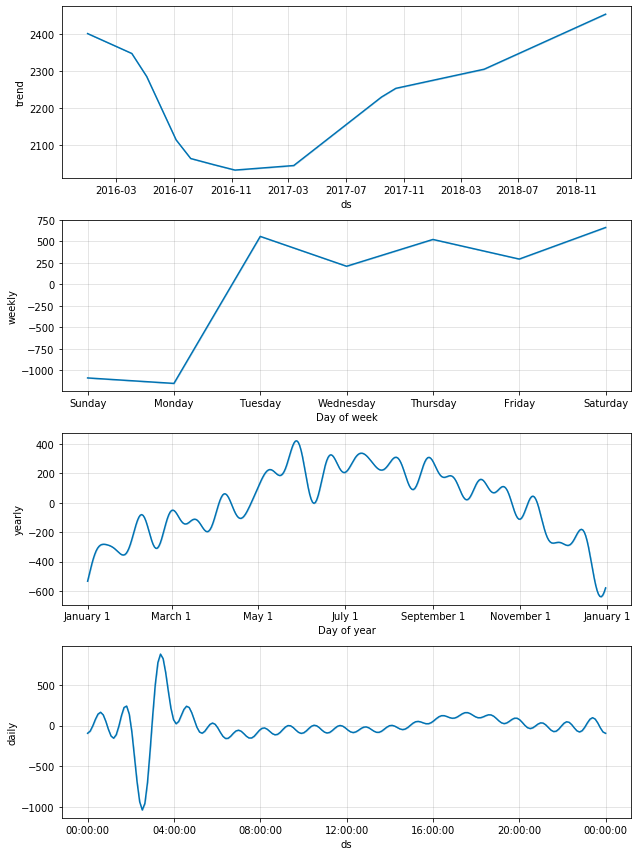

In [22]:
data_fig = model.plot(forecast)
components_fig = model.plot_components(forecast)

data_fig.show()
components_fig.show()

We can also save our reconstruction and the plots on file:

In [23]:
results_dir = create_results_dir()

data_fig.savefig(os.path.join(results_dir, "data_plot.pdf"))
components_fig.savefig(os.path.join(results_dir, "STL_components_plot.pdf"))

forecast.to_csv(os.path.join(results_dir, "results.csv"), sep=',')